# Hyperparameter Tuning Convergence Visualization

This notebook compares the convergence behavior of Random Search vs. Bayesian Optimization for X-learner hyperparameter tuning.

In [10]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from skopt import Optimizer
from skopt.space import Integer
from sklearn.model_selection import ParameterSampler
from scipy.stats import randint

from src.dgp import SimulatedDataset
from src.xlearner import XlearnerWrapper
from src.tuning import evaluate_params_cv

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 5)

## 1. Generate Dataset

In [11]:
# Generate a simulated dataset
print("Generating dataset...")
dgp = SimulatedDataset(N=1000, d=15, alpha=0.5, seed=42)

print(f"Dataset: N={dgp.N}, d={dgp.d}")
print(f"Treatment distribution: {np.mean(dgp.W):.2%} treated")
print(f"True average treatment effect: {np.mean(dgp.tau):.3f}")

Generating dataset...
Dataset: N=1000, d=15
Treatment distribution: 30.40% treated
True average treatment effect: 0.527


## 2. Define Search Space and Base Estimator

In [12]:
# Base estimator
base_estimator = XlearnerWrapper(
    models=RandomForestRegressor(random_state=0),
    propensity_model=LogisticRegression(random_state=0)
)

# Parameter space for random search
param_dist_random = {
    'models__n_estimators': randint(20, 150),
    'models__max_depth': randint(3, 15),
    'models__min_samples_leaf': randint(1, 20)
}

# Parameter space for Bayesian optimization
param_dist_bayes = {
    'models__n_estimators': Integer(20, 150),
    'models__max_depth': Integer(3, 15),
    'models__min_samples_leaf': Integer(1, 20)
}

print("Search space defined:")
print("  - n_estimators: [20, 150]")
print("  - max_depth: [3, 15]")
print("  - min_samples_leaf: [1, 20]")

Search space defined:
  - n_estimators: [20, 150]
  - max_depth: [3, 15]
  - min_samples_leaf: [1, 20]


## 3. Run Random Search with Tracking

In [13]:
print("\nRunning Random Search...")
n_iter = 50
cv = 5
random_state = 42

random_scores = []
random_best_scores = []
random_params_history = []

best_score_random = np.inf

for i, params in enumerate(ParameterSampler(param_dist_random, n_iter=n_iter, random_state=random_state)):
    score = evaluate_params_cv(
        base_estimator, params, dgp.X, dgp.Y, dgp.W, cv=cv, random_state=random_state
    )
    
    random_scores.append(score)
    random_params_history.append(params)
    
    if score < best_score_random:
        best_score_random = score
    
    random_best_scores.append(best_score_random)
    
    if (i + 1) % 10 == 0:
        print(f"  Iteration {i+1}/{n_iter}: Best MSE = {best_score_random:.4f}")

print(f"\nRandom Search completed. Best MSE: {best_score_random:.4f}")


Running Random Search...
  Iteration 10/50: Best MSE = 1.2234
  Iteration 20/50: Best MSE = 1.2234
  Iteration 30/50: Best MSE = 1.2234
  Iteration 40/50: Best MSE = 1.2234
  Iteration 50/50: Best MSE = 1.2234

Random Search completed. Best MSE: 1.2234


## 4. Run Bayesian Optimization with Tracking

In [14]:
print("\nRunning Bayesian Optimization...")

param_names = list(param_dist_bayes.keys())
dimensions = list(param_dist_bayes.values())

optimizer = Optimizer(
    dimensions=dimensions,
    base_estimator="GP",
    acq_func="EI",
    random_state=random_state
)

bayes_scores = []
bayes_best_scores = []
bayes_params_history = []

best_score_bayes = np.inf

for i in range(n_iter):
    x = optimizer.ask()
    params = dict(zip(param_names, x))
    
    score = evaluate_params_cv(
        base_estimator, params, dgp.X, dgp.Y, dgp.W, cv=cv, random_state=random_state
    )
    
    optimizer.tell(x, score)
    
    bayes_scores.append(score)
    bayes_params_history.append(params)
    
    if score < best_score_bayes:
        best_score_bayes = score
    
    bayes_best_scores.append(best_score_bayes)
    
    if (i + 1) % 10 == 0:
        print(f"  Iteration {i+1}/{n_iter}: Best MSE = {best_score_bayes:.4f}")

print(f"\nBayesian Optimization completed. Best MSE: {best_score_bayes:.4f}")


Running Bayesian Optimization...
  Iteration 10/50: Best MSE = 1.2232
  Iteration 20/50: Best MSE = 1.2232
  Iteration 30/50: Best MSE = 1.2232
  Iteration 40/50: Best MSE = 1.2232
  Iteration 50/50: Best MSE = 1.2232

Bayesian Optimization completed. Best MSE: 1.2232


## 5. Visualize Convergence

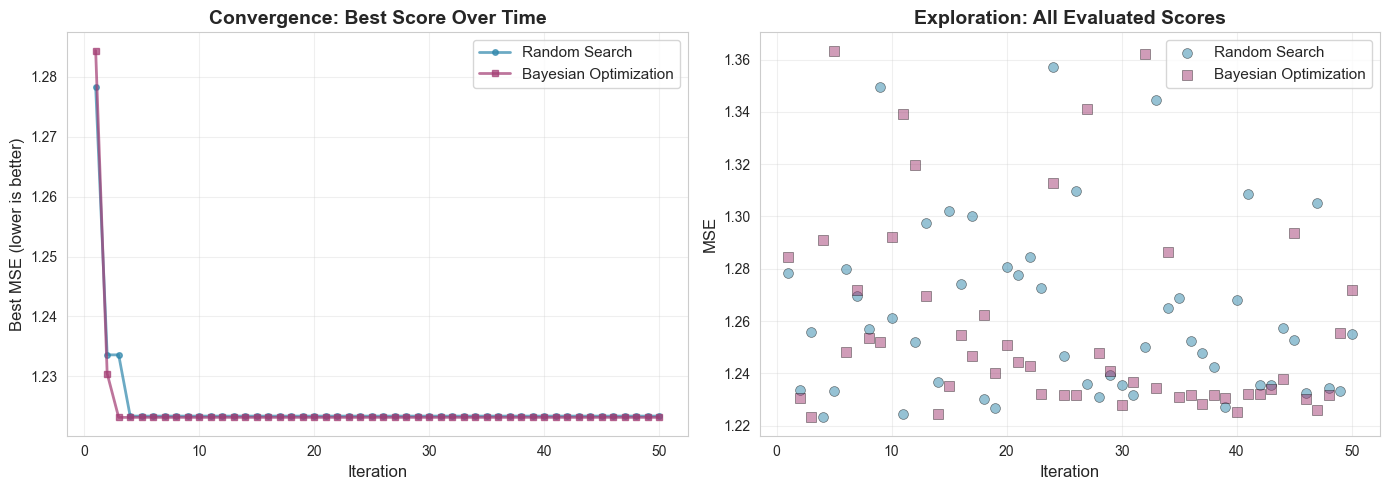


Visualization saved as 'tuning_convergence.png'


In [15]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Best Score Over Time (Convergence)
ax1 = axes[0]
iterations = np.arange(1, n_iter + 1)

ax1.plot(iterations, random_best_scores, 'o-', label='Random Search', 
         color='#2E86AB', linewidth=2, markersize=4, alpha=0.7)
ax1.plot(iterations, bayes_best_scores, 's-', label='Bayesian Optimization', 
         color='#A23B72', linewidth=2, markersize=4, alpha=0.7)

ax1.set_xlabel('Iteration', fontsize=12)
ax1.set_ylabel('Best MSE (lower is better)', fontsize=12)
ax1.set_title('Convergence: Best Score Over Time', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot 2: All Scores (Exploration)
ax2 = axes[1]

ax2.scatter(iterations, random_scores, label='Random Search', 
            color='#2E86AB', alpha=0.5, s=50, edgecolors='black', linewidth=0.5)
ax2.scatter(iterations, bayes_scores, label='Bayesian Optimization', 
            color='#A23B72', alpha=0.5, s=50, marker='s', edgecolors='black', linewidth=0.5)

ax2.set_xlabel('Iteration', fontsize=12)
ax2.set_ylabel('MSE', fontsize=12)
ax2.set_title('Exploration: All Evaluated Scores', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('tuning_convergence.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization saved as 'tuning_convergence.png'")

## 6. Summary Statistics

In [16]:
print("\n" + "="*60)
print("CONVERGENCE ANALYSIS")
print("="*60)

print(f"\nRandom Search:")
print(f"  Best MSE:        {best_score_random:.4f}")
print(f"  Mean MSE:        {np.mean(random_scores):.4f}")
print(f"  Std MSE:         {np.std(random_scores):.4f}")
print(f"  Worst MSE:       {np.max(random_scores):.4f}")

print(f"\nBayesian Optimization:")
print(f"  Best MSE:        {best_score_bayes:.4f}")
print(f"  Mean MSE:        {np.mean(bayes_scores):.4f}")
print(f"  Std MSE:         {np.std(bayes_scores):.4f}")
print(f"  Worst MSE:       {np.max(bayes_scores):.4f}")

improvement = ((best_score_random - best_score_bayes) / best_score_random) * 100
print(f"\nImprovement: {improvement:.2f}% {'(Bayesian better)' if improvement > 0 else '(Random better)'}")

# Find iteration where best score was found
random_best_iter = np.argmin(random_scores) + 1
bayes_best_iter = np.argmin(bayes_scores) + 1

print(f"\nBest score found at iteration:")
print(f"  Random Search:   {random_best_iter}/{n_iter}")
print(f"  Bayesian Opt:    {bayes_best_iter}/{n_iter}")


CONVERGENCE ANALYSIS

Random Search:
  Best MSE:        1.2234
  Mean MSE:        1.2621
  Std MSE:         0.0328
  Worst MSE:       1.3570

Bayesian Optimization:
  Best MSE:        1.2232
  Mean MSE:        1.2570
  Std MSE:         0.0365
  Worst MSE:       1.3634

Improvement: 0.02% (Bayesian better)

Best score found at iteration:
  Random Search:   4/50
  Bayesian Opt:    3/50


## 7. Parameter Space Exploration

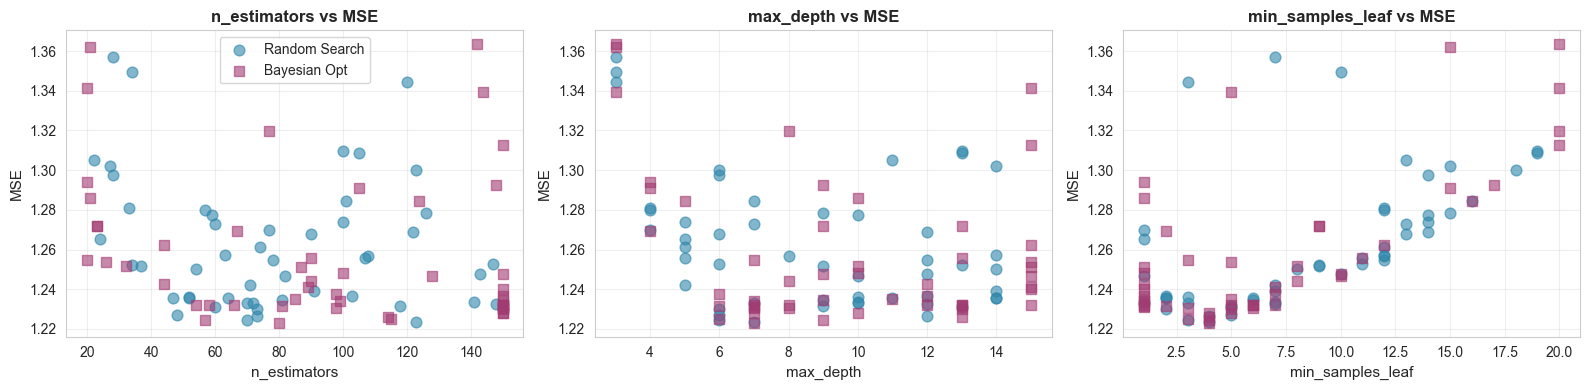


Parameter exploration visualization saved as 'parameter_exploration.png'


In [17]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

param_names_plot = ['models__n_estimators', 'models__max_depth', 'models__min_samples_leaf']
param_labels = ['n_estimators', 'max_depth', 'min_samples_leaf']

for idx, (param_name, param_label) in enumerate(zip(param_names_plot, param_labels)):
    ax = axes[idx]
    
    # Extract parameter values
    random_param_vals = [p[param_name] for p in random_params_history]
    bayes_param_vals = [p[param_name] for p in bayes_params_history]
    
    # Plot
    ax.scatter(random_param_vals, random_scores, 
               label='Random Search', color='#2E86AB', alpha=0.6, s=60)
    ax.scatter(bayes_param_vals, bayes_scores, 
               label='Bayesian Opt', color='#A23B72', alpha=0.6, s=60, marker='s')
    
    ax.set_xlabel(param_label, fontsize=11)
    ax.set_ylabel('MSE', fontsize=11)
    ax.set_title(f'{param_label} vs MSE', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    if idx == 0:
        ax.legend(fontsize=10)

plt.tight_layout()
plt.savefig('parameter_exploration.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nParameter exploration visualization saved as 'parameter_exploration.png'")

## 8. Best Hyperparameters

In [18]:
best_params_random = random_params_history[np.argmin(random_scores)]
best_params_bayes = bayes_params_history[np.argmin(bayes_scores)]

print("\n" + "="*60)
print("BEST HYPERPARAMETERS")
print("="*60)

print("\nRandom Search:")
for param, value in best_params_random.items():
    print(f"  {param}: {value}")

print("\nBayesian Optimization:")
for param, value in best_params_bayes.items():
    print(f"  {param}: {value}")

print("\n" + "="*60)
print("EXPERIMENT COMPLETE")
print("="*60)


BEST HYPERPARAMETERS

Random Search:
  models__max_depth: 7
  models__min_samples_leaf: 4
  models__n_estimators: 123

Bayesian Optimization:
  models__n_estimators: 80
  models__max_depth: 7
  models__min_samples_leaf: 4

EXPERIMENT COMPLETE
